# Parallel message passing for HMMs

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/probml/dynamax/blob/main/dynamax/hmm/demos/parallel_message_passing.ipynb)

**Note: you should run this notebook on a machine with a GPU in order to see the benefits of parallelization.**

The standard message passing algorithm for HMMs is the forward-backward algorithm. On the forward pass, the algorithm computes the filtering distributions, $p(z_t \mid x_{1:t})$, for $t=1,\ldots,T$. Then, on the backward pass, it computes the smoothing distributions, $p(z_t \mid x_{1:T})$, for $t=T,\ldots,1$. This algorithm is inherently sequential, and it takes $O(T)$ time. 

Given how standard this algorithm is, it may be surprising to learn that the same filtering and smoothing distributions can be computed in $O(\log T)$ time using a _parallel_ message passing algorithm, if you can access $O(T)$ parallel processors. The key insight is that the forward-backward algorithm is summing out (eliminating) one latent variable at a time, but you could eliminate multiple variables in parallel, as long as they do not have any direct dependencies. In a chain structured graphical model, like a HMM, that means you can eliminate every odd numbered node in parallel. Recursing this operation yields a logarithmic-time algorithm for inference in HMMs. 

[Hassan et al (2021)](https://arxiv.org/pdf/2102.05743.pdf) give a thorough description of how this algorithm works. First, write the posterior distribution over latent states of the HMM in its undirected graphical model form,
\begin{align}
p(z_{1:T} \mid x_{1:T}) &= \frac{1}{p(x_{1:T})} \prod_{t=0}^{T-1} \psi_{t,t+1}(z_t, z_{t+1})
\end{align}
where
\begin{align}
\psi_{t,t+1}(z_t, z_{t+1}) 
&= p(z_{t+1}, x_{t+1} \mid z_t) 
= p(z_{t+1} \, \mid z_t) \, p(x_{t+1} \mid z_{t+1})
\end{align}
is a _potential_, and, by convention, $p(z_1 \mid z_0) = p(z_1)$ is the initial distribution.

Hassan et al. use a clever trick to simplify the subsequent algorithm. Use the chain rule to swap the order of the terms in the potential,
\begin{align}
\psi_{t,t+1}(z_t, z_{t+1}) 
&\equiv \underbrace{p(x_{t+1} \mid z_t)}_{b_{t,t+1}} \, \underbrace{p(z_{t+1} \mid z_t, x_{t+1})}_{A_{t,t+1}}
\end{align}
where $A_{t,t+1} \in \mathbb{R}^{K \times K}$ is a row normalized matrix and $b_{t,t+1} \in \mathbb{R}^K$.
(Now $b_{0,1} = p(x_1)$ and $A_{0,1} = p(z_1 \mid x_1)$.)

The binary associative operator takes in two potentials and outputs one potential, summing out the shared variables,
\begin{align}
\psi_{t,t+2}(z_t, z_{t+2}) 
&= \sum_{z_{t+1}} \psi_{t,t+1}(z_t, z_{t+1}) \, \psi_{t+1,t+2}(z_{t+1}, z_{t+2}) \\
&= p(x_{t+1}, x_{t+2}, z_{t+2} \mid z_t) \\
&= \underbrace{p(z_{t+2} \mid x_{t+1}, x_{t+2}, z_t)}_{A_{t,t+2}} \, \underbrace{p(x_{t+1}, x_{t+2} \mid z_t)}_{b_{t,t+2}}
\end{align}
where, again, $A_{t,t+2} \in \mathbb{R}^{K \times K}$ is a row normalized matrix and $b_{t,t+2} \in \mathbb{R}^K$. (In practice, we work with $\log b$ for numerical stability.) The algebra to compute $A_{t,t+2}$ and $b_{t,t+2}$ is straightforward but somewhat tedious, so we omit it here. 

At the end of the associative scan, we'll end up with $A_{0,t} = p(z_t \mid x_{1:t})$ and $b_{0,t} = p(x_{1:t})$ for all $t=1,\ldots,T.$ These are exactly the filtering distributions and marginal likelihoods output by the sequential forward algorithm! 


In [ ]:
try:
    import dynamax
except:
    %pip install -U -q git+https://github.com/probml/dynamax.git

In [ ]:
import jax.numpy as jnp
import jax.random as jr
from jax import jit
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import HMMPosterior, hmm_filter, parallel_hmm_filter, hmm_smoother, parallel_hmm_smoother

# Test that the sequential and parallel filter return the same results

In [ ]:
def random_hmm_args(key, num_timesteps, num_states, scale=3.0):
    k1, k2, k3 = jr.split(key, 3)
    initial_probs = jr.uniform(k1, (num_states,))
    initial_probs /= initial_probs.sum()
    transition_matrix = jr.uniform(k2, (num_states, num_states))
    transition_matrix /= transition_matrix.sum(1, keepdims=True)
    log_likelihoods = scale * jr.normal(k3, (num_timesteps, num_states))
    return initial_probs, transition_matrix, log_likelihoods


num_timesteps = 10000
num_states = 25
initial_probs, transition_matrix, log_likelihoods = \
    random_hmm_args(jr.PRNGKey(0), num_timesteps, num_states)

In [ ]:
hmm_filter = jit(hmm_filter)
posterior = hmm_filter(initial_probs, transition_matrix, log_likelihoods)

In [ ]:
parallel_hmm_filter = jit(parallel_hmm_filter)
posterior2 = parallel_hmm_filter(initial_probs, transition_matrix, log_likelihoods)

In [ ]:
print("marginal log likelihoods:")
print("sequential", posterior.marginal_loglik)
print("parallel", posterior2.marginal_loglik)
jnp.allclose(posterior.marginal_loglik / num_timesteps, posterior2.marginal_loglik / num_timesteps, atol=1e-3)

marginal log likelihoods:
sequential 32845.906
parallel 32845.938


DeviceArray(True, dtype=bool)

In [ ]:
print("max absolute error in filtered probabilities")
print(jnp.max(abs(posterior.filtered_probs - posterior2.filtered_probs)))
jnp.allclose(posterior.filtered_probs, posterior2.filtered_probs, atol=1e-1)

max absolute error in filtered probabilities
8.940697e-07


DeviceArray(True, dtype=bool)

In [ ]:
print("max absolute error in predicted probabilities")
print(jnp.max(abs(posterior.predicted_probs - posterior2.predicted_probs)))
jnp.allclose(posterior.predicted_probs, posterior2.predicted_probs, atol=1e-1)

max absolute error in predicted probabilities
7.4505806e-08


DeviceArray(True, dtype=bool)

Text(0, 0.5, 'rmse of predicted probs')

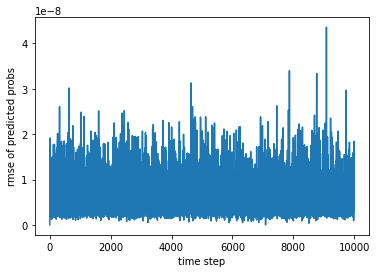

In [ ]:
# Plot the RMSE in predicted probabilities over time
rmse = lambda x, y: jnp.sqrt(jnp.mean((x - y)**2, axis=1))
plt.plot(rmse(posterior.predicted_probs, posterior2.predicted_probs))
plt.xlabel("time step")
plt.ylabel("rmse of predicted probs")

## Timing comparison

In [ ]:
%%timeit 
posterior = hmm_filter(initial_probs, transition_matrix, log_likelihoods)
posterior.marginal_loglik.block_until_ready()

214 ms ± 6.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit 
posterior = parallel_hmm_filter(initial_probs, transition_matrix, log_likelihoods)
posterior.marginal_loglik.block_until_ready()

3.99 ms ± 24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Now compare the smoother 

In [ ]:
hmm_smoother = jit(hmm_smoother)
posterior = hmm_smoother(initial_probs, transition_matrix, log_likelihoods)

In [ ]:
parallel_hmm_smoother = jit(parallel_hmm_smoother)
posterior2 = parallel_hmm_smoother(initial_probs, transition_matrix, log_likelihoods)

In [ ]:
print("marginal log likelihoods:")
print("sequential", posterior.marginal_loglik)
print("parallel", posterior2.marginal_loglik)
jnp.allclose(posterior.marginal_loglik / num_timesteps, posterior2.marginal_loglik / num_timesteps, atol=1e-3)

marginal log likelihoods:
sequential 32845.906
parallel 32845.938


DeviceArray(True, dtype=bool)

In [ ]:
print("max absolute error in smoothed probabilities")
print(jnp.max(abs(posterior.smoothed_probs - posterior2.smoothed_probs)))
jnp.allclose(posterior.smoothed_probs, posterior2.smoothed_probs, atol=1e-1)

max absolute error in smoothed probabilities
0.00015495718


DeviceArray(True, dtype=bool)

Text(0, 0.5, 'rmse of smoothed probs')

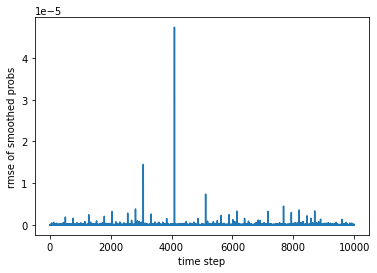

In [ ]:
rmse = lambda x, y: jnp.sqrt(jnp.mean((x - y)**2, axis=1))
plt.plot(rmse(posterior.smoothed_probs, posterior2.smoothed_probs))
plt.xlabel("time step")
plt.ylabel("rmse of smoothed probs")

In [ ]:
%%timeit 
posterior = hmm_smoother(initial_probs, transition_matrix, log_likelihoods)
posterior.marginal_loglik.block_until_ready()

355 ms ± 5.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit 
posterior = parallel_hmm_smoother(initial_probs, transition_matrix, log_likelihoods)
posterior.marginal_loglik.block_until_ready()

14.7 ms ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Make a figure

In [ ]:
import time

K = 20
Ts = [100, 1000, 10000, 100000, 1000000]
n_repeats = 3
compiled = False
serial_durations = []
parallel_durations = []
f_s = hmm_filter
f_p = parallel_hmm_filter
for T in Ts:
    print("T", T)
    initial_probs, transition_matrix, log_likelihoods = \
        random_hmm_args(jr.PRNGKey(0), T, K)

    print("serial")
    if not compiled:
        posterior = f_s(initial_probs, transition_matrix, log_likelihoods)    
        posterior.marginal_loglik.block_until_ready()
    
    start = time.time()
    for _ in range(n_repeats):
        posterior = f_s(initial_probs, transition_matrix, log_likelihoods)    
        posterior.marginal_loglik.block_until_ready()
    end = time.time()
    serial_durations.append((end - start) / n_repeats)

    print("parallel")
    if not compiled:
        posterior = f_p(initial_probs, transition_matrix, log_likelihoods)    
        posterior.marginal_loglik.block_until_ready()
    
    start = time.time()
    for _ in range(n_repeats):
        posterior = f_p(initial_probs, transition_matrix, log_likelihoods)    
        posterior.marginal_loglik.block_until_ready()
    end = time.time()
    parallel_durations.append((end - start) / n_repeats)

T 100
serial
parallel
T 1000
serial
parallel
T 10000
serial
parallel
T 100000
serial
parallel
T 1000000
serial
parallel


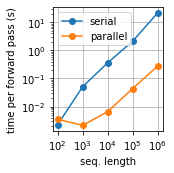

In [ ]:
plt.figure(figsize=(2.5, 2.5))
plt.loglog(Ts, serial_durations, '-o', label='serial')
plt.loglog(Ts, parallel_durations, '-o', label='parallel')
plt.xticks(Ts)
plt.xlabel("seq. length")
plt.ylabel("time per forward pass (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig("parallel_scan_profiling_filter.pdf")
# plt.savefig("parallel_scan_profiling_filter.png")